# 【問題1】クロスバリデーション
事前学習期間では検証データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。


事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [2]:
# データの読み込み
train = pd.read_csv('../../kaggledata/application_train.csv')
test = pd.read_csv('../../kaggledata/application_test.csv')

In [3]:
cols = ['TARGET', 'EXT_SOURCE_3', 'EXT_SOURCE_2',
        'EXT_SOURCE_1', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY',
        'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH',
        'REG_CITY_NOT_WORK_CITY', 'AMT_CREDIT', 'AMT_ANNUITY',
        'DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'NAME_EDUCATION_TYPE',
        'CODE_GENDER', 'NAME_INCOME_TYPE', 'EMERGENCYSTATE_MODE',
        'AMT_INCOME_TOTAL']

train_data = train.copy()
train_data = train_data[cols]
train_data.head()

,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,CODE_GENDER,NAME_INCOME_TYPE,EMERGENCYSTATE_MODE,AMT_INCOME_TOTAL
0,1,0.139376,0.262949,0.083037,-9461,2,2,-1134.0,-2120,0,406597.5,24700.5,-637,351000.0,Secondary / secondary special,M,Working,No,202500.0
1,0,NaN,0.622246,0.311267,-16765,1,1,-828.0,-291,0,1293502.5,35698.5,-1188,1129500.0,Higher education,F,State servant,No,270000.0
2,0,0.729567,0.555912,NaN,-19046,2,2,-815.0,-2531,0,135000.0,6750.0,-225,135000.0,Secondary / secondary special,M,Working,NaN,67500.0
3,0,NaN,0.650442,NaN,-19005,2,2,-617.0,-2437,0,312682.5,29686.5,-3039,297000.0,Secondary / secondary special,F,Working,NaN,135000.0
4,0,NaN,0.322738,NaN,-19932,2,2,-1106.0,-3458,1,513000.0,21865.5,-3038,513000.0,Secondary / secondary special,M,Working,NaN,121500.0


In [4]:
# 前処理
le = LabelEncoder()

for i in cols:
    if train_data[i].dtype=='O':
        train_data[i] = train_data[i].fillna('na')
        train_data[i] = le.fit_transform(train_data[i].values)
    else:
        train_data[i] = train_data[i].fillna(0)
        
X = train_data.iloc[:, 1:].values
y = train_data[['TARGET']].values

### クロスバリデーション

In [5]:
# from sklearn.model_selection import KFold

# ５回クロスバリデーションを行う。
kf = KFold(n_splits=5)
kf.get_n_splits(X)

def kf_test(param=1.0):
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        # 特徴量を標準化
        scaler_x = StandardScaler()
        scaler_x.fit(X_train)
        X_train_std = scaler_x.transform(X_train)
        X_test_std = scaler_x.transform(X_test)

        # 学習
        model = LogisticRegression(random_state=0, C=param)
        model.fit(X_train_std, y_train)

        # 推定
        pred_train = model.predict_proba(X_train_std)[:, 1]
        pred_test = model.predict_proba(X_test_std)[:, 1]

        # 評価
        pred_acu_train = roc_auc_score(y_train, pred_train)
        pred_auc_test = roc_auc_score(y_test, pred_test)

        print(f'train, test: {pred_acu_train, pred_auc_test}')
        
kf_test()

train, test: (0.718365623311919, 0.7184756400250214)
train, test: (0.7183610781361238, 0.7188308544112227)
train, test: (0.7195296346172084, 0.7139493314584582)
train, test: (0.7183510289486363, 0.7182657804074286)
train, test: (0.7176238819623078, 0.7212502620765011)


# 【問題2】グリッドサーチ
これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。


scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。

GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。

### グリッドサーチ

In [6]:
# from sklearn.model_selection import GridSearchCV

def GridSearchCV_test():
    # データセットを読み込む

    # 教師データとラベルデータを取り出す
    X = train_data.iloc[:, 1:].values
    y = train_data[['TARGET']].values

    # 標準化
    scaler_x = StandardScaler()
    scaler_x.fit(X)
    X_std = scaler_x.transform(X)

    # 優れたハイパーパラメータを見つけたいモデル
    model = LogisticRegression(random_state=0)

    # 試行するパラメータを羅列する
    params = {'C': [10**i for i in range(-3, 3)]}

    grid_search = GridSearchCV(model,  # 分類器を渡す
                               param_grid=params,  # 試行してほしいパラメータを渡す
                               cv=5,  # 5-Fold CV で汎化性能を調べる
                               n_jobs=-1,
                               scoring='roc_auc'
                               )

    # グリッドサーチで優れたハイパーパラメータを探す
    grid_search.fit(X, y)

    print(grid_search.best_score_)  # 最も良かったスコア
    print(grid_search.best_params_)  # 上記を記録したパラメータの組み合わせ

GridSearchCV_test()

0.6204227216667546
{'C': 0.01}


In [7]:
# C=0.01
kf_test(0.01)

train, test: (0.7179156290366462, 0.7183702138007816)
train, test: (0.7179075791360106, 0.71855318040729)
train, test: (0.7191308387844957, 0.7132397897928451)
train, test: (0.7179445880741706, 0.7177207498472623)
train, test: (0.7172061743723687, 0.7207833232639831)


# 【問題3】Kaggle Notebooksからの調査
KaggleのNotebooksから様々なアイデアを見つけ出して、列挙してください。

- LightGBMで学習する。
- CREDIT_INCOME_PERCENT：クライアントの収入に対するクレジット額の割合
- ANNUITY_INCOME_PERCENT：クライアントの収入に対するローン年金の割合
- CREDIT_TERM：支払いの月数（年金は毎月の支払い期日であるため）
- DAYS_EMPLOYED_PERCENT：クライアントの年齢に対する就業日の割合

# 【問題4】高い汎化性能のモデル作成
問題3で見つけたアイデアと、独自のアイデアを組み合わせ高い汎化性能のモデル作りを進めてください。


その過程として、何を行うことで、クロスバリデーションの結果がどの程度変化したかを表にまとめてください。

### ① LightGBMで学習

In [8]:
X = train_data.iloc[:, 1:]
y = train_data[['TARGET']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape

(230633, 18)

In [9]:
import lightgbm as lgb

# 訓練・検証データの設定
lgb_train = lgb.Dataset(data=X_train, label=y_train)
lgb_test = lgb.Dataset(data=X_test, label=y_test)

params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}

model = lgb.train(params, lgb_train, valid_sets=lgb_test, early_stopping_rounds=150, verbose_eval=200)

Training until validation scores don't improve for 150 rounds
[200]	valid_0's auc: 0.743704
[400]	valid_0's auc: 0.75027
[600]	valid_0's auc: 0.753616
[800]	valid_0's auc: 0.7551
[1000]	valid_0's auc: 0.755998
[1200]	valid_0's auc: 0.756542
[1400]	valid_0's auc: 0.756658
[1600]	valid_0's auc: 0.756704
Early stopping, best iteration is:
[1541]	valid_0's auc: 0.756804


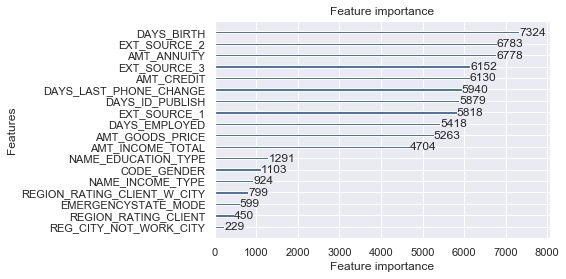

In [10]:
lgb.plot_importance(model);

### ② LightGBM + ４つの新しい特徴量を追加

In [11]:
# 新しい特徴量を追加
train_data['CREDIT_INCOME_PERCENT'] = train_data['AMT_CREDIT'] / train_data['AMT_INCOME_TOTAL']
train_data['ANNUITY_INCOME_PERCENT'] = train_data['AMT_ANNUITY'] / train_data['AMT_INCOME_TOTAL']
train_data['CREDIT_TERM'] = train_data['AMT_ANNUITY'] / train_data['AMT_CREDIT']
train_data['DAYS_EMPLOYED_PERCENT'] = train_data['DAYS_EMPLOYED'] / train_data['DAYS_BIRTH']

In [12]:
X = train_data.iloc[:, 1:]
y = train_data[['TARGET']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape

(230633, 22)

In [13]:
# 訓練・検証データの設定
lgb_train = lgb.Dataset(data=X_train, label=y_train)
lgb_test = lgb.Dataset(data=X_test, label=y_test)

params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': 'auc', 
          'learning_rate': 0.01, 
          'num_leaves': 48, 
          'num_iteration': 5000, 
          'verbose': 0 ,
          'colsample_bytree':.8, 
          'subsample':.9, 
          'max_depth':7, 
          'reg_alpha':.1, 
          'reg_lambda':.1, 
          'min_split_gain':.01, 
          'min_child_weight':1
         }

model = lgb.train(params, 
                  lgb_train, 
                  valid_sets=lgb_test, 
                  early_stopping_rounds=150, 
                  verbose_eval=200
                 )

Training until validation scores don't improve for 150 rounds
[200]	valid_0's auc: 0.747358
[400]	valid_0's auc: 0.756578
[600]	valid_0's auc: 0.761439
[800]	valid_0's auc: 0.763436
[1000]	valid_0's auc: 0.764446
[1200]	valid_0's auc: 0.764939
[1400]	valid_0's auc: 0.765275
Early stopping, best iteration is:
[1370]	valid_0's auc: 0.765319


>最高スコアが得られた。

### 変更点
- LogisticRegression → lightgbm
- 新しい特徴量追加

### 変更前  
train, test: (0.7179156290366462, 0.7183702138007816)  
train, test: (0.7179075791360106, 0.71855318040729)  
train, test: (0.7191308387844957, 0.7132397897928451)  
train, test: (0.7179445880741706, 0.7177207498472623)  
train, test: (0.7172061743723687, 0.7207833232639831)  

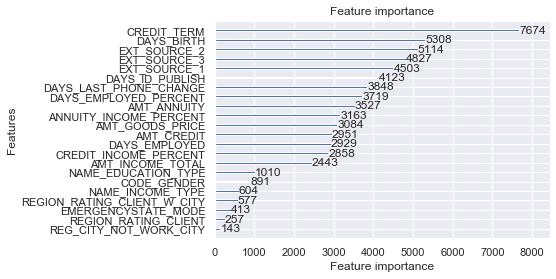

In [14]:
lgb.plot_importance(model);

# 【問題5】最終的なモデルの選定
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

### 問題４の②のパターンで提出する。

In [15]:
# 前処理
test_data = test.copy()
cols = ['EXT_SOURCE_3', 'EXT_SOURCE_2',
        'EXT_SOURCE_1', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY',
        'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH',
        'REG_CITY_NOT_WORK_CITY', 'AMT_CREDIT', 'AMT_ANNUITY',
        'DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'NAME_EDUCATION_TYPE',
        'CODE_GENDER', 'NAME_INCOME_TYPE', 'EMERGENCYSTATE_MODE',
        'AMT_INCOME_TOTAL']
test_data = test_data[cols]

le = LabelEncoder()
for i in cols:
    if test_data[i].dtype=='O':
        test_data[i] = test_data[i].fillna('na')
        test_data[i] = le.fit_transform(test_data[i].values)
    else:
        test_data[i] = test_data[i].fillna(0)

test_data['CREDIT_INCOME_PERCENT'] = test_data['AMT_CREDIT'] / test_data['AMT_INCOME_TOTAL']
test_data['ANNUITY_INCOME_PERCENT'] = test_data['AMT_ANNUITY'] / test_data['AMT_INCOME_TOTAL']
test_data['CREDIT_TERM'] = test_data['AMT_ANNUITY'] / test_data['AMT_CREDIT']
test_data['DAYS_EMPLOYED_PERCENT'] = test_data['DAYS_EMPLOYED'] / test_data['DAYS_BIRTH']

In [16]:
# 推定
pred = model.predict(test_data)

In [17]:
submission =pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': pred})
submission.to_csv('submission_HomeCredit3.csv', index=False)

In [18]:
pd.read_csv('submission_HomeCredit3.csv')

,SK_ID_CURR,TARGET
0,100001,0.017648
1,100005,0.056891
2,100013,0.017058
3,100028,0.038054
4,100038,0.135007
...,...,...
48739,456221,0.029242
48740,456222,0.085182
48741,456223,0.016775
48742,456224,0.035912


![画像](https://gyazo.com/e90b376e0070c97211774b8e2903266d.gng)

>汎用性を求めた時の優先すべきは、EDA ＞= 学習モデル種類 ＞ 前処理 ＞ パラメータチューニング という印象であった。